<a href="https://colab.research.google.com/github/MovinduSenura/Chest-Xray-Pneumonia-Detection/blob/dev-sayuri/notebooks/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports

import os

In [4]:
# Clone GITHUB Repository

if not os.path.exists('Chest-Xray-Pneumonia-Detection'):
    !git clone https://github.com/MovinduSenura/Chest-Xray-Pneumonia-Detection.git

Cloning into 'Chest-Xray-Pneumonia-Detection'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 103 (delta 22), reused 5 (delta 5), pack-reused 68 (from 2)
Receiving objects: 100% (103/103), 49.90 KiB | 3.84 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [5]:
#Go into the project directory

%cd Chest-Xray-Pneumonia-Detection


/content/Chest-Xray-Pneumonia-Detection


In [23]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Dataset Location

DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/chest_xray'

In [30]:
# Create TRAIN/VAL/TEST Generators

from notebooks.preprocessing import create_generators
train_gen, val_gen, test_gen = create_generators(DATA_DIR)
print("Data generators created successfully!\n")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data generators created successfully!



In [27]:
# Import VGG16 and Build Model

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers (freeze all except last few)
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 10,290,945 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [29]:
# Train the Model

history = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 748ms/step - accuracy: 0.9375 - loss: 0.1655 - val_accuracy: 0.7500 - val_loss: 0.5429
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 754ms/step - accuracy: 0.9648 - loss: 0.0954 - val_accuracy: 0.7500 - val_loss: 0.2826
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 761ms/step - accuracy: 0.9691 - loss: 0.0879 - val_accuracy: 0.6875 - val_loss: 0.5314
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 739ms/step - accuracy: 0.9702 - loss: 0.0790 - val_accuracy: 0.9375 - val_loss: 0.1505
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 753ms/step - accuracy: 0.9734 - loss: 0.0702 - val_accuracy: 0.8125 - val_loss: 0.4190


In [33]:
# Evaluate Test Accuracy and Loss

test_loss, test_acc = model.evaluate(test_gen)

print(f"🟩 Test Accuracy: {test_acc * 100:.2f}%")
print(f"🟥 Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.8852 - loss: 0.4711
🟩 Test Accuracy: 91.67%
🟥 Test Loss: 0.3293


In [35]:
#  Evaluate on Training Data

train_loss, train_acc = model.evaluate(train_gen)
print(f"🟩 Training Accuracy: {train_acc * 100:.2f}%")
print(f"🟥 Training Loss: {train_loss : .4f}")



163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 734ms/step - accuracy: 0.9800 - loss: 0.0476
🟩 Training Accuracy: 98.29%
🟥 Training Loss:  0.0442


In [37]:
#  Evaluate Validation Accuracy and Loss after training
val_loss, val_acc = model.evaluate(val_gen)

# Print both results
print(f"🟩 Validation Accuracy: {val_acc * 100:.2f}%")
print(f"🟥 Validation Loss: {val_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8125 - loss: 0.4190
🟩 Validation Accuracy: 81.25%
🟥 Validation Loss: 0.4190


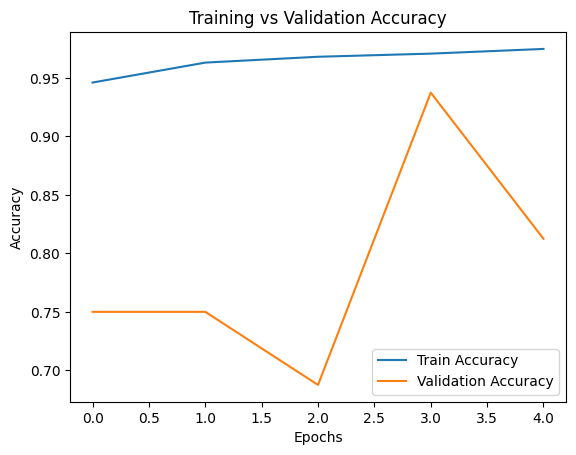

In [38]:
# Plot training vs validation accuracy

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Since test accuracy is a single value (not per epoch) we cant draw a graph including test accuracy
